In [1]:
import pandas as pd

# -----------------------------------------------------------
# 1. GDP DATASET LADEN
# -----------------------------------------------------------

gdp_path = r"C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/additional_data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_308461.csv"
gdp_raw = pd.read_csv(gdp_path, skiprows=3)

# Year columns finden
year_cols = [col for col in gdp_raw.columns if col.isdigit()]

# Long format
gdp_long = gdp_raw.melt(
    id_vars=["Country Name", "Country Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="GDP_per_capita"
)

gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce").astype("Int64")

# -----------------------------------------------------------
# 2. DEIN REFUGEE DATENSATZ LADEN
# -----------------------------------------------------------

refugee_new_path = r"C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/output_csv_files/Destination_refugees_per_capita.csv"
ref_new = pd.read_csv(refugee_new_path)

# Year als Zahl
ref_new["Year"] = pd.to_numeric(ref_new["Year"], errors="coerce").astype("Int64")

print(ref_new.head())

# -----------------------------------------------------------
# 3. MERGE AUSFÜHREN (EXAKT FÜR DEINE SPALTEN)
# -----------------------------------------------------------

merged_final = pd.merge(
    ref_new,
    gdp_long[["Country Code", "Year", "GDP_per_capita"]],
    left_on=["country_code", "Year"],   # aus deinem Datensatz
    right_on=["Country Code", "Year"],  # aus World Bank GDP Dataset
    how="left"
)

print("Merged shape:", merged_final.shape)
print(merged_final.head())

# -----------------------------------------------------------
# 4. ABSPEICHERN
# -----------------------------------------------------------

output_path = (
    r"C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/output_csv_files/"
    "Destination_refugees_per_capita_with_gdp.csv"
)
merged_final.to_csv(output_path, index=False)

print("Saved:", output_path)


       country  Year  Refugee_amount country_code  Population  refugee_share  \
0  Afghanistan  1990            50.0          AFG  12045660.0       0.000004   
1  Afghanistan  1991            38.0          AFG  12238879.0       0.000003   
2  Afghanistan  1992         60025.0          AFG  13278974.0       0.004520   
3  Afghanistan  1993         32132.0          AFG  14943172.0       0.002150   
4  Afghanistan  1994         19131.0          AFG  16250794.0       0.001177   

   share_per_1000  
0        0.004151  
1        0.003105  
2        4.520304  
3        2.150280  
4        1.177235  
Merged shape: (6023, 9)
       country  Year  Refugee_amount country_code  Population  refugee_share  \
0  Afghanistan  1990            50.0          AFG  12045660.0       0.000004   
1  Afghanistan  1991            38.0          AFG  12238879.0       0.000003   
2  Afghanistan  1992         60025.0          AFG  13278974.0       0.004520   
3  Afghanistan  1993         32132.0          AFG  1494

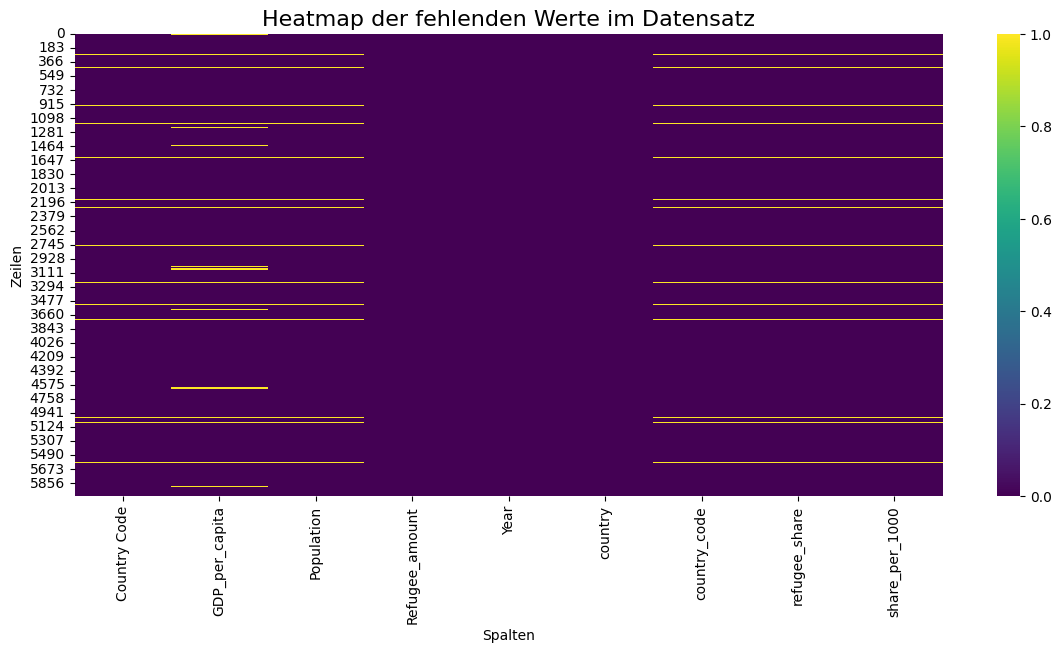

In [2]:
import sys
sys.executable


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# Datensatz laden
# -----------------------------------------------------------

path = r"C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/output_csv_files/Destination_refugees_per_capita_with_gdp.csv"
df = pd.read_csv(path)

# Ensure column ordering is preserved
df = df.sort_index(axis=1)

# -----------------------------------------------------------
# Heatmap erstellen
# -----------------------------------------------------------

plt.figure(figsize=(14, 6))
sns.heatmap(df.isna(), cbar=True, cmap="viridis")

plt.title("Heatmap der fehlenden Werte im Datensatz", fontsize=16)
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()


(5556, 9)


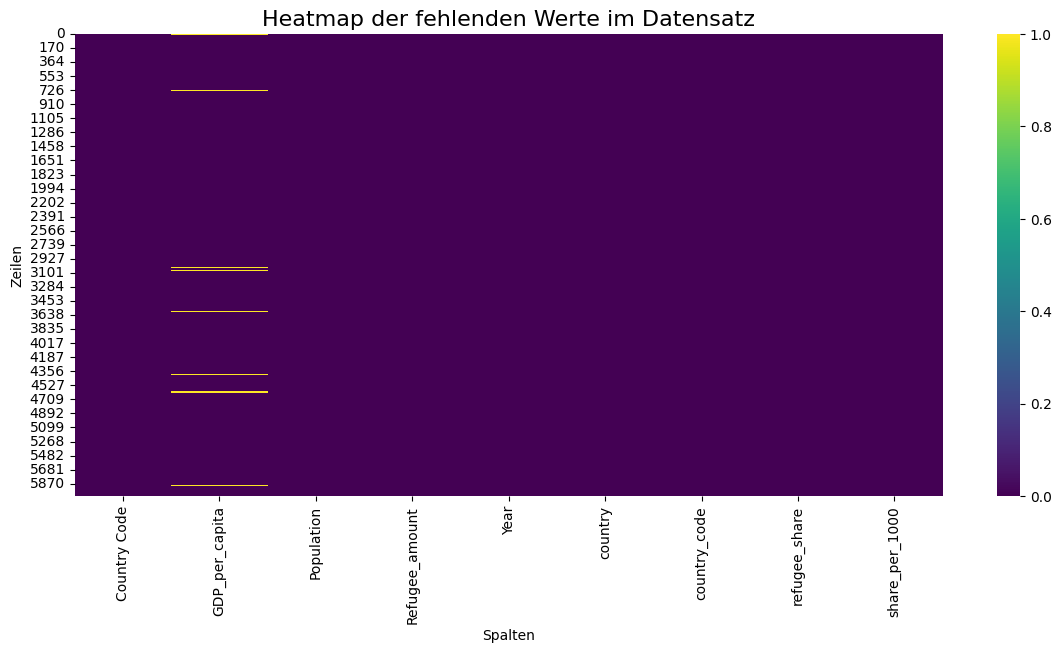

In [3]:
df_clean = df[df["Year"] >= 1970].copy()

print(df_clean.shape)
df_clean.head()


plt.figure(figsize=(14, 6))
sns.heatmap(df_clean.isna(), cbar=True, cmap="viridis")

plt.title("Heatmap der fehlenden Werte im Datensatz", fontsize=16)
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()

In [4]:
# Schritt 1: NaN-Analyse pro Spalte
nan_report = pd.DataFrame({
    "missing_count": df_clean.isna().sum(),
    "missing_percent": df_clean.isna().mean() * 100
}).sort_values("missing_percent", ascending=False)

nan_report


,missing_count,missing_percent
GDP_per_capita,132,2.37581
Country Code,0,0.00000
Population,0,0.00000
Refugee_amount,0,0.00000
Year,0,0.00000
country,0,0.00000
country_code,0,0.00000
refugee_share,0,0.00000
share_per_1000,0,0.00000


In [5]:
# Alle Zeilen, wo GDP fehlt
missing_gdp = df_clean[df_clean["GDP_per_capita"].isna()]

# Übersicht: wie viele fehlende Werte pro Land
missing_by_country = (
    missing_gdp.groupby("country")[["Year"]]
    .count()
    .rename(columns={"Year": "missing_years"})
    .sort_values("missing_years", ascending=False)
)

missing_by_country


,missing_years
country,
Serbia and Kosovo (S/RES/1244 (1999)),25
Mozambique,16
Lebanon,15
Viet Nam,11
Lao People's Dem. Rep.,10
Djibouti,9
Afghanistan,8
Romania,8
"China, Macao SAR",7


In [6]:
# Länder, die komplett ohne GDP Werte sind:
countries_no_gdp = (
    df_clean.groupby("country")["GDP_per_capita"]
    .apply(lambda x: x.isna().all())
)

countries_no_gdp[countries_no_gdp == True]


country
British Virgin Islands         True
Dem. People's Rep. of Korea    True
Name: GDP_per_capita, dtype: bool

In [7]:
df_clean = df_clean.sort_values(["country", "Year"]).reset_index(drop=True)

df_clean["GDP_per_capita_interpolated"] = (
    df_clean.groupby("country")["GDP_per_capita"]
    .transform(lambda x: x.interpolate(method="linear", limit_area="inside"))
)


In [8]:
df_final = df_clean.dropna(subset=["GDP_per_capita_interpolated"]).copy()

df_final["GDP_per_capita"] = df_final["GDP_per_capita_interpolated"]
df_final = df_final.drop(columns=["GDP_per_capita_interpolated"])


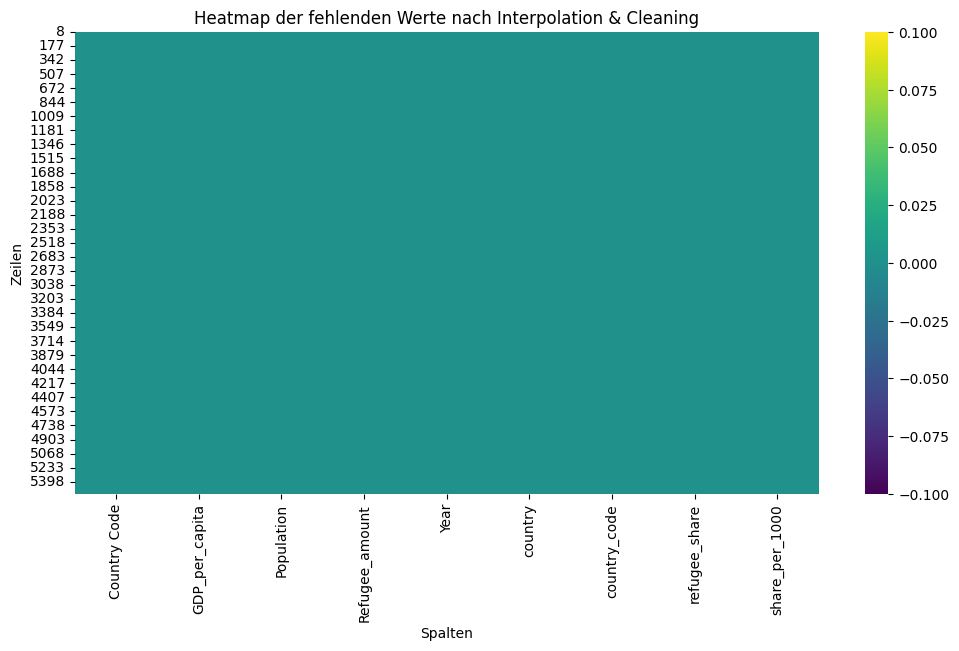

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(df_final.isna(), cbar=True, cmap="viridis")
plt.title("Heatmap der fehlenden Werte nach Interpolation & Cleaning")
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()


In [10]:
# Anzahl fehlender Werte VOR der Interpolation
missing_before = df_clean["GDP_per_capita"].isna().sum()

# Anzahl fehlender Werte NACH der Interpolation & Dropping
missing_after = df_final["GDP_per_capita"].isna().sum()

# Anzahl imputierter Werte
imputed = missing_before - missing_after

print("Anzahl GDP Missing Before:", missing_before)
print("Anzahl GDP Missing After:", missing_after)
print("Imputierte Werte (interpoliert):", imputed)

print("\nZeilen vorher:", df_clean.shape)
print("Zeilen nachher:", df_final.shape)
print("Entfernte Zeilen:", df_clean.shape[0] - df_final.shape[0])
output_path = r"C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/output_csv_files/Destination_refugees_per_capita_with_gdp_cleaned.csv"

df_final.to_csv(output_path, index=False)

print("Gespeichert unter:", output_path)



Anzahl GDP Missing Before: 132
Anzahl GDP Missing After: 0
Imputierte Werte (interpoliert): 132

Zeilen vorher: (5556, 10)
Zeilen nachher: (5425, 9)
Entfernte Zeilen: 131
Gespeichert unter: C:/Users/paulk/My_Drive/Statistik/Statistik_Projekt/output_csv_files/Destination_refugees_per_capita_with_gdp_cleaned.csv
